# Assignments

## Week 04

*"Due date": 04.04.2022* 

### Exercise 01: a short programming riddle

Let's read some output of the OGGM model ([download the data](https://github.com/fmaussion/advanced_programming/raw/master/book/data/oggm_fl_ela.nc)): 

In [ ]:
import xarray as xr
with xr.open_dataset('../data/oggm_fl_ela.nc') as ds:
    ds = ds.load()

In [ ]:
ds.thickness_m.sel(time=[2004, 2019]).plot(hue='time');

In [ ]:
ds.area_m2.sum(dim='dis_along_flowline').plot();

In [ ]:
ds.ela_m.plot();

These data represent a glacier simulation using the [flowline](https://docs.oggm.org/en/stable/flowlines.html) representation. Each grid point on the flowline has a width, an area, and a thickness changing with time:

In [ ]:
ds.bed_h.plot(color='k');

surface_h = ds.bed_h + ds.thickness_m
surface_h.sel(time=[2004, 2019]).plot(hue='time');

**Your task is to compute the yearly "accumulation area ratio" (AAR)**, which is a number between 0 and 1 representing the fraction of the glacier area which is *above* the equilibrium line altitude (ELA). You have all the data you need above: 
- `ds.ela_m` represents the equilibrium line altitude (ELA) each year (unit: m)
- `surface_h` represents the surface elevation of the glacier grid points each year (unit: m). With this you can check which grid points are located above the ELA.
- `ds.area_m2` represents the area of each grid point each year (same dimensions as `surface_h`, unit: m2). With this you can compute the total area of the glacier each year (plotted above) and together with the ELA and `surface_h` you can compute the AAR. 

The "difficulty" of this programming exercise is that all variables change each year. An intuitive way to solve the problem would be to use a for loop and you may want to start with this if you want to.

In fact, one can do it without for loop in 4 lines of code in xarray or numpy (the code in xarray is simpler than in pure numpy). If the task with xarray was too easy for you, you can try to code the same without xarray.

### Exercise 02: code profiling

[Pydemic](https://github.com/fmaussion/pydemic) is an agent-based model of a pandemic used to teach OOP to master students. 

The code is very slow, because it does not use vectors to represent data. Each agent in the model has a location and state stored in scalar variables. This is OK given the purpose of the tool (teaching OOP), but we can still do better.

Run the `pydemic.py` module (no installation needed, a `python pydemic.py` should suffice to create a plot) and spend some time studying its code (it should be relatively straightforward). The code is quite slow though (a single simulation takes about 23s on my laptop). 

**Your task is to profile pydemic and find at least one bottleneck in the code**. For the profiling, use [py-spy](https://github.com/benfred/py-spy) to run the module (remove the plot function from `__main__` first!!!). **Once you have found the bottleneck, implement or design a strategy to address it.**

## Week 05: Numerical modelling

*"Due date": 25.04.2022* 

The [glacier_model.py](https://raw.githubusercontent.com/fmaussion/advanced_programming/master/book/02_performance/glacier_model.py) script (`shift` + `right click` to download) contains numerical code to realize glacier flowline experiments. The code is similar to what [OGGM](https://docs.oggm.org/en/stable/ice-dynamics.html) is doing, but with some simplifications:
- the glacier has a rectangular bed shape and is of constant width 
- the mass balance is a simple linear function of elevation

The model solves the continuity equation as a numerical diffusion problem (see the seminal paper by [Oerlemans 1997](https://www.cambridge.org/core/journals/annals-of-glaciology/article/flowline-model-for-nigardsbreen-norway-projection-of-future-glacier-length-based-on-dynamic-calibration-with-the-historic-record/238EA486EB8CCBC77A0C292047FC03CD) if you are interested about the origins of such models: our code is the same but without the trapezoid shape and without basal sliding). There are a few things to say about the time stepping scheme (which is fixed to a constant value which is a bad idea), but numerics are not what we are trying to improve here. 

Let's consider the following:

In [1]:
from glacier_model import glacier_evolution
import matplotlib.pyplot as plt
import numpy as np
xc, bed_h, surface_h, years, volume, length = glacier_evolution()

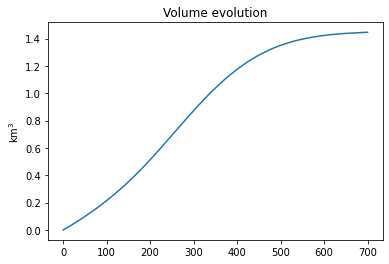

In [2]:
plt.plot(years, volume*1e-9); plt.title('Volume evolution'); plt.ylabel('km$^{3}$');

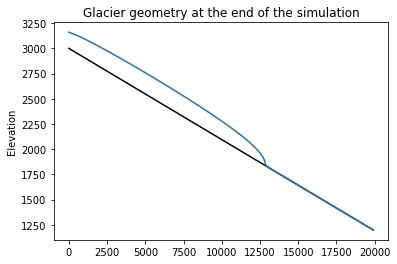

In [3]:
plt.plot(xc, bed_h, color='k'); plt.plot(xc, surface_h);
plt.title('Glacier geometry at the end of the simulation'); plt.ylabel('Elevation');

In [4]:
%timeit glacier_evolution()

3.25 s ± 72.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's make this code faster in two steps (which is also what you should do in real life)

### "Micro-"optimizations 

Your task: **profile** the code and evaluate the bottlenecks, and **optimize** what can be optimized. 

With a few very simple changes in the code (all related to the examples discussed in the [lecture notes](class_notes.ipynb)), I was able to make the code faster by a factor of two:

In [5]:
from glacier_model_optim import glacier_evolution_optim
%timeit glacier_evolution_optim()

1.77 s ± 32.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


And then in class I also showed you numba:

In [6]:
from glacier_model_optim_numb import glacier_evolution_optim_numba
%timeit glacier_evolution_optim_numba()

152 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Multiprocessing 

Let's consider the following sensitivity experiments (taking way too long):

In [ ]:
volumes = []
grads = np.linspace(1, 5, 3)
for grad in grads:
    xc, bed_h, surface_h, years, volume, length = glacier_evolution_optim(mb_grad=grad)
    volumes.append(volume)
volumes = np.array(volumes)

In [ ]:
plt.plot(grads, volumes[:, -1] * 1e-9, 'o-');

In [ ]:
plt.plot(years, volumes.T * 1e-9);

**What if we want to make 100 experiments instead of 3?**

The problem is what we call [embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel): each task is fully independent of the others.

**Use python's multiprocessing `Pool.map()` method to realize the same experiments on the MB gradient but with input `np.linspace(1, 5, 20)` instead.** 

The output plot should look more something like: 

![img](example_plot.png)

Repeat with another sensitivity experiment of your choice!